Imports

In [1]:
import torch as nn
import torch.nn
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation
from Dreamer import Dreamer
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml
import argparse
from DreamerUtils import _sanitize_for_save
torch.set_float32_matmul_precision('high')

In [ ]:
log_path = './logs/training_logs.npz'

if not os.path.exists(log_path):
        print(f"Error: File not found at {log_path}")

# Load the .npz file
try:
    data = np.load(log_path, allow_pickle=True)
    print("Keys found in logs:", list(data.keys()))
except Exception as e:
    print(f"Failed to load log file: {e}")

wm_loss = data['world_model_loss']
if wm_loss.ndim > 1:
    wm_loss = wm_loss.mean(axis=1) # Average over epochs if multiple exist per step
    
actor_loss = data['actor_loss']
critic_loss = data['critic_loss']
rewards = data['rewards']

Keys found in logs: ['world_model_loss', 'actor_loss', 'critic_loss', 'rewards']


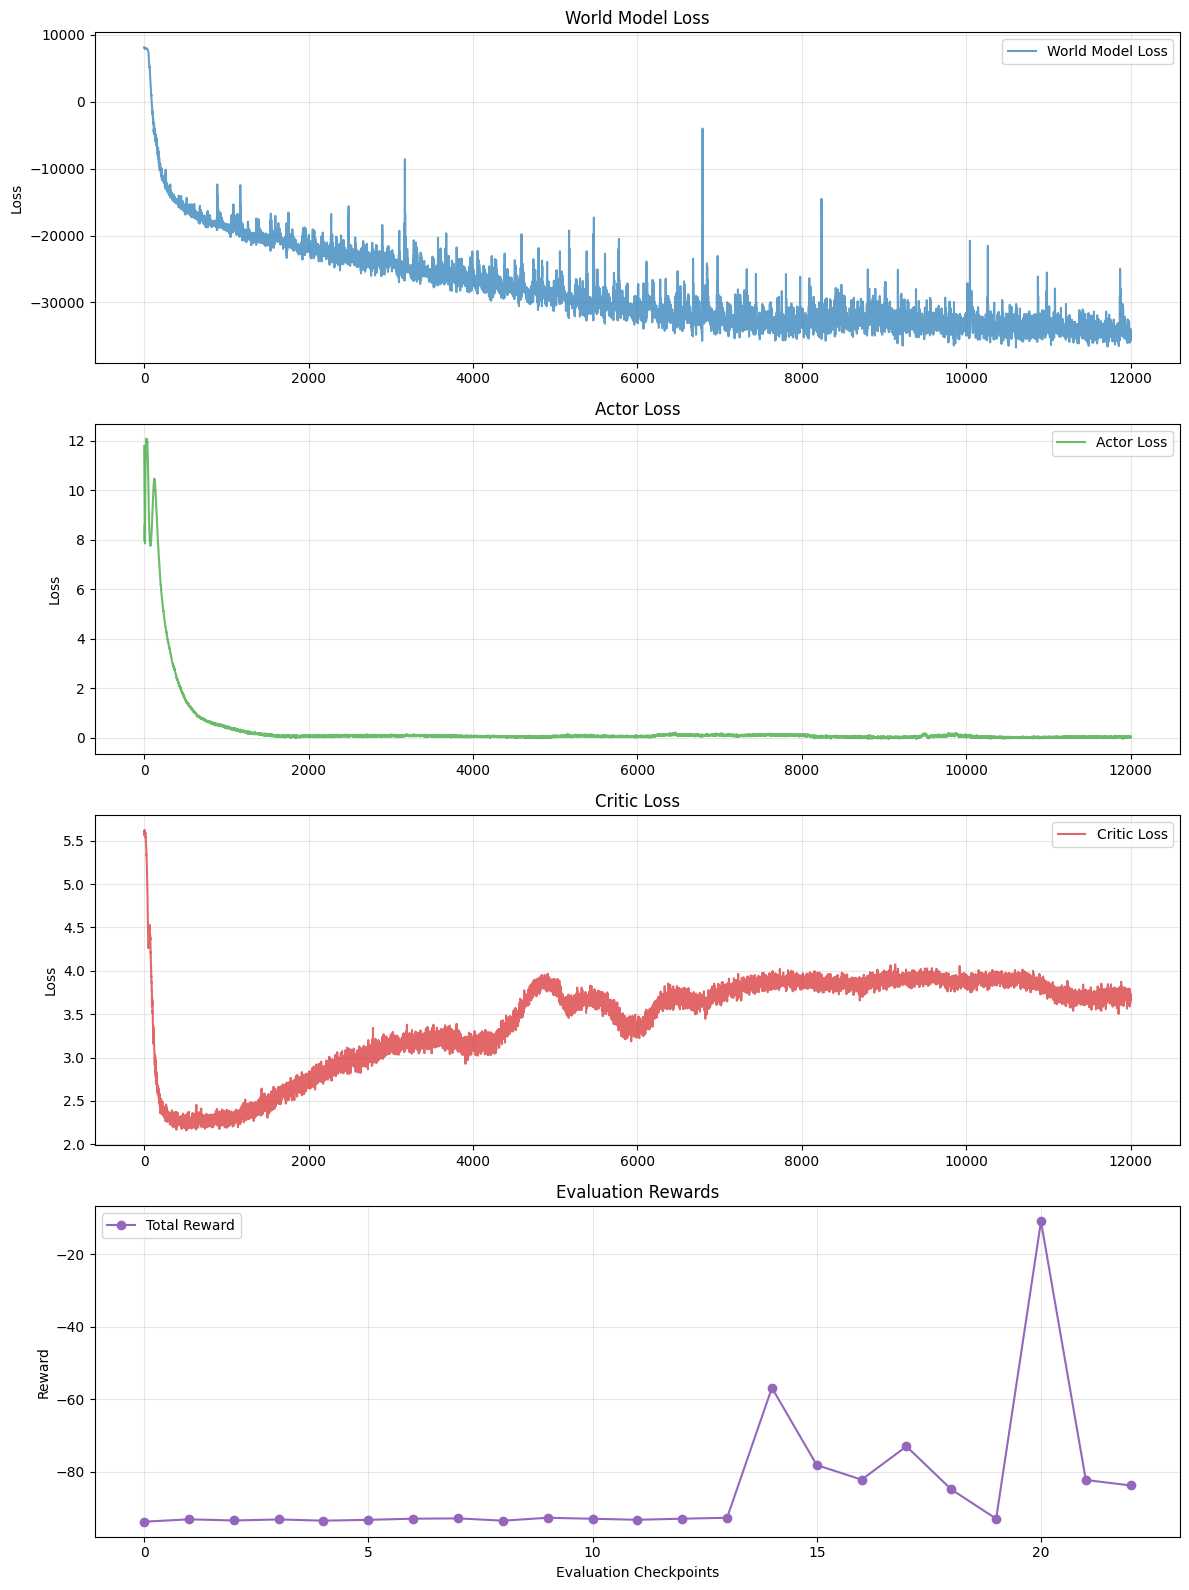

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=False)

# 1. World Model Loss
axs[0].plot(wm_loss, label='World Model Loss', color='tab:blue', alpha=0.7)
axs[0].set_title('World Model Loss')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# 2. Actor Loss
axs[1].plot(actor_loss, label='Actor Loss', color='tab:green', alpha=0.7)
axs[1].set_title('Actor Loss')
axs[1].set_ylabel('Loss')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# 3. Critic Loss
axs[2].plot(critic_loss, label='Critic Loss', color='tab:red', alpha=0.7)
axs[2].set_title('Critic Loss')
axs[2].set_ylabel('Loss')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

# 4. Rewards (Evaluation)
# Rewards are logged less frequently, so the x-axis will be different (evaluation steps)
axs[3].plot(rewards, label='Total Reward', color='tab:purple', marker='o', linestyle='-')
axs[3].set_title('Evaluation Rewards')
axs[3].set_ylabel('Reward')
axs[3].set_xlabel('Evaluation Checkpoints')
axs[3].grid(True, alpha=0.3)
axs[3].legend()

plt.tight_layout()

In [5]:
from Adaptors import CarRacerAdaptor, ActionRepeat
env_id = "CarRacing-v3"
evaluation_env = gym.make(env_id, continuous=True, render_mode="human")
evaluation_env = ResizeObservation(evaluation_env, tuple([64, 64]))
evaluation_env = ActionRepeat(CarRacerAdaptor(evaluation_env), repeat=4)

In [6]:
config_path = 'car_racer_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {config['device']}")
device = torch.device(config['device'])

dreamer_agent = Dreamer(
    config,
    device=device
)

Using Device: cuda


In [ ]:
path = './models/agent.pth'
dreamer_agent.load_pretrained_dreamer(path)

In [24]:
reward = dreamer_agent.Run(evaluation_env, 42, render=True)
print(reward)

KeyboardInterrupt: 